<a href="https://colab.research.google.com/github/asabbah44/Text_Classification/blob/main/WordEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [2]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/dataset.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/mydataset.csv')


df1 = pd.DataFrame(df1, columns = ['commenttext','label'])
df2 = pd.DataFrame(df2, columns = ['commenttext','label'])

df=pd.concat([df1,df2])
#df=df2

In [3]:
# possible_labels = df.label.unique()
# label_dict = {}
# for index, possible_label in enumerate(possible_labels):
#     label_dict[possible_label] = index
# print(label_dict)
# df['label'] = df.label.replace(label_dict)

# df.head()

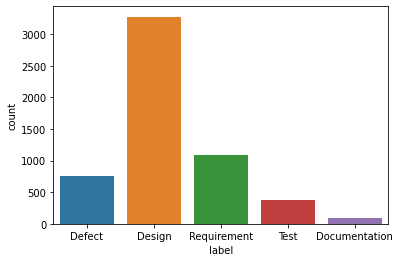

In [4]:
import seaborn as sns

sns.countplot(x='label', data=df)

In [5]:
# import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks')

# from Utility import preprocess
# df["commenttext"] = df["commenttext"].apply(lambda x: x.lower())

# # Clean the text
# df["commenttext"] = df["commenttext"].apply(lambda x:preprocess.clean_text(x))

# # Clean numbers
# df["commenttext"] = df["commenttext"].apply(lambda x:preprocess.clean_numbers(x))

# # Clean Contractions
# df["commenttext"] = df["commenttext"].apply(lambda x:preprocess.replace_contractions(x))
 
# df["commenttext"] = df["commenttext"].apply(lambda x:preprocess.clean_punc(x))

# # lemmatize
# df["commenttext"] = df["commenttext"].apply(lambda x: preprocess.lemmatize(x))
# # remove stop word and custome word such as todo
# df["commenttext"] = df["commenttext"].apply(lambda x: preprocess.custm_stopwords_remove(x))



In [6]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
X = []
sentences = list(df['commenttext'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [9]:
X[2]

' hate to admit it but we don know what happened here Throw the Exception '

Label encoder

In [10]:
df.label.unique()

array(['Defect', 'Design', 'Requirement', 'Test', 'Documentation'],
      dtype=object)

In [11]:
y = df['label']

y = np.array(list(map(lambda x: 0 if x=="Requirement" else 1 if x=="Design" else 2 if x=="Defect" else 3 if x=="Test" else 4, y)))


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)



In [13]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train = le.fit_transform(y_train.values)
# y_test = le.transform(y_test.values)

In [14]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
all_words = []
for sent in X:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
unique_words = set(all_words)

No_Of_Words=(len(unique_words))
print(No_Of_Words)

9597


In [16]:
tokenizer = Tokenizer(num_words=No_Of_Words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(df.commenttext, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
print(length_long_sentence)

1394


In [18]:
MaxWordsLen=length_long_sentence

In [19]:
vocab_size = len(tokenizer.word_index) + 1

# max number of words in sentencecs
maxlen = MaxWordsLen

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [20]:
vocab_size 

7179

Chose which model to use

In [21]:
model_type=3 # 1-word2vec , 2- Glove, 
EMBEDDING_DIM=300

In [28]:
from numpy import array
from numpy import asarray
from numpy import zeros
import gensim
from gensim import corpora, models, similarities

embeddings_dictionary = dict()
if(model_type==2) :

 glove_file = open('/content/drive/MyDrive/Colab Notebooks/glove.840B.300d.txt', encoding="utf8")

 for line in glove_file:
    records = line.split(" ")
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
 glove_file.close()

elif (model_type==1):
 w2v_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz', binary=True)
 word_vectors = w2v_model
 word_index = tokenizer.word_index
 for word, i in word_index.items():
    if i>=No_Of_Words:
        continue
    try:
        embedding_vector = word_vectors[word]
        embeddings_dictionary[word] = embedding_vector
    except KeyError:
      continue
      #  embeddings_dictionary[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

 del(word_vectors)

elif (model_type==3):
       !pip install tqdm
       from gensim.models.wrappers import FastText
       from tqdm import tqdm
       print('loading FastText word embeddings...')
       embeddings_index = {}
       f = open('/content/drive/MyDrive/Colab Notebooks/crawl-300d-2M.vec',encoding='utf-8')
       for line in tqdm(f):
        values = line.strip().rsplit(' ')
        word = values[0]
        vector_dimensions = np.asarray(values[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
       f.close()
else:
   print("No Model")

0it [00:00, ?it/s]

loading FastText word embeddings...


1999996it [02:38, 12588.70it/s]


In [29]:
WordsNotInclude=[]
embedding_matrix = zeros((vocab_size,  EMBEDDING_DIM))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else : WordsNotInclude.append(word)

In [30]:
len(WordsNotInclude)

1825

ANN

In [55]:
model = Sequential()
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen , trainable=True)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(5, activation='softmax'))

In [56]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1394, 300)         2153700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 418200)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 2091005   
Total params: 4,244,705
Trainable params: 4,244,705
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Epoch 1/6
28/28 [==============================] - 4s 130ms/step - loss: 1.2561 - acc: 0.5346 - val_loss: 1.0331 - val_acc: 0.6421
Epoch 2/6
28/28 [==============================] - 4s 126ms/step - loss: 0.7994 - acc: 0.6935 - val_loss: 0.9205 - val_acc: 0.6588
Epoch 3/6
28/28 [==============================] - 4s 127ms/step - loss: 0.5869 - acc: 0.7971 - val_loss: 0.8655 - val_acc: 0.7025
Epoch 4/6
28/28 [==============================] - 4s 126ms/step - loss: 0.4467 - acc: 0.8711 - val_loss: 0.8230 - val_acc: 0.7215
Epoch 5/6
28/28 [==============================] - 4s 126ms/step - loss: 0.3397 - acc: 0.9105 - val_loss: 0.8278 - val_acc: 0.7271
Epoch 6/6
28/28 [==============================] - 4s 127ms/step - loss: 0.2572 - acc: 0.9361 - val_loss: 0.8091 - val_acc: 0.7260


In [34]:
score = model.evaluate(X_test, y_test, verbose=1)

35/35 [==============================] - 0s 12ms/step - loss: 0.8520 - acc: 0.7081


In [35]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.851997971534729
Test Accuracy: 0.7081468105316162


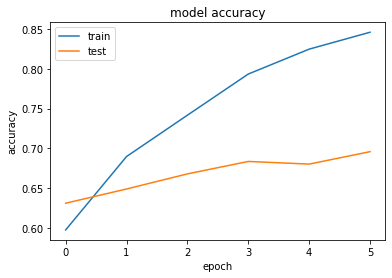

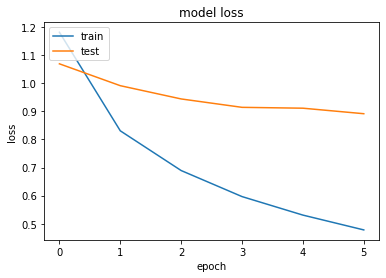

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

Simple CNN

In [70]:
from keras.layers import Conv1D, MaxPooling1D, Embedding
model = Sequential()

embedding_layer = Embedding( vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen , trainable=True)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [71]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1394, 300)         2153700   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1390, 128)         192128    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 2,346,473
Trainable params: 2,346,473
Non-trainable params: 0
_________________________________________________________________
None


In [72]:
history1 = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
28/28 [==============================] - 6s 191ms/step - loss: 1.1962 - acc: 0.5387 - val_loss: 0.8620 - val_acc: 0.6846
Epoch 2/10
28/28 [==============================] - 5s 185ms/step - loss: 0.6590 - acc: 0.7596 - val_loss: 0.7119 - val_acc: 0.7248
Epoch 3/10
28/28 [==============================] - 5s 187ms/step - loss: 0.4662 - acc: 0.8383 - val_loss: 0.6686 - val_acc: 0.7394
Epoch 4/10
28/28 [==============================] - 5s 186ms/step - loss: 0.3147 - acc: 0.9181 - val_loss: 0.6203 - val_acc: 0.7562
Epoch 5/10
28/28 [==============================] - 5s 185ms/step - loss: 0.2101 - acc: 0.9594 - val_loss: 0.6249 - val_acc: 0.7562
Epoch 6/10
28/28 [==============================] - 5s 186ms/step - loss: 0.1428 - acc: 0.9786 - val_loss: 0.6109 - val_acc: 0.7662
Epoch 7/10
28/28 [==============================] - 5s 186ms/step - loss: 0.0981 - acc: 0.9853 - val_loss: 0.6351 - val_acc: 0.7640
Epoch 8/10
28/28 [==============================] - 5s 186ms/step - loss: 0.

In [73]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.7348574995994568
Test Accuracy: 0.7573858499526978


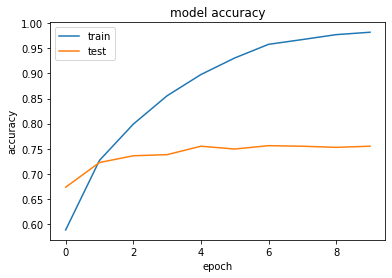

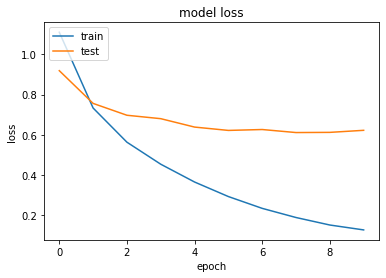

In [41]:
import matplotlib.pyplot as plt

plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

 CNN Functinal 

In [42]:
from keras.layers import Input
from keras.models import Model

cnn_model = Sequential()
embedding_layer = Embedding( vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = "relu"))
cnn_model.add(MaxPooling1D(pool_size = 2))
cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = "relu"))
cnn_model.add(MaxPooling1D(pool_size = 2))
cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = "relu"))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(units = 128, activation = 'relu'))
cnn_model.add(Dense(units = 5, activation = 'softmax'))


In [43]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1394, 300)         2153700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1390, 128)         192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 695, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 691, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 345, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 341, 128)          82048     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)              

In [44]:
#Configures the model for training
cnn_model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["acc"])
#Split the dataset into train and validation set for training and evaludating the model
# X_train, X_val, y_train, y_val = train_test_split(trainvalid_data, train_labels, shuffle = True, random_state = 123)
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
#Trains the model for a fixed number of epochs (iterations on a dataset)
history = cnn_model.fit(X_train, y_train, batch_size = 128, epochs = 10, validation_split=0.2)
score = cnn_model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
28/28 [==============================] - 5s 156ms/step - loss: 1.3070 - acc: 0.5333 - val_loss: 1.1100 - val_acc: 0.5872
Epoch 2/10
28/28 [==============================] - 4s 141ms/step - loss: 1.0657 - acc: 0.5814 - val_loss: 1.0738 - val_acc: 0.5872
Epoch 3/10
28/28 [==============================] - 4s 141ms/step - loss: 0.9161 - acc: 0.6024 - val_loss: 0.9244 - val_acc: 0.6499
Epoch 4/10
28/28 [==============================] - 4s 140ms/step - loss: 0.7048 - acc: 0.7243 - val_loss: 0.8523 - val_acc: 0.6689
Epoch 5/10
28/28 [==============================] - 4s 141ms/step - loss: 0.4384 - acc: 0.8496 - val_loss: 0.7849 - val_acc: 0.7304
Epoch 6/10
28/28 [==============================] - 4s 142ms/step - loss: 0.2752 - acc: 0.9153 - val_loss: 0.8667 - val_acc: 0.7282
Epoch 7/10
28/28 [==============================] - 4s 141ms/step - loss: 0.1269 - acc: 0.9680 - val_loss: 1.0504 - val_acc: 0.7472
Epoch 8/10
28/28 [==============================] - 4s 142ms/step - loss: 0.

In [45]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.3550091981887817
Test Accuracy: 0.7027752995491028


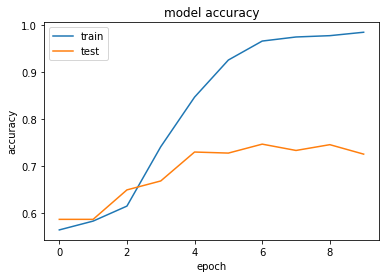

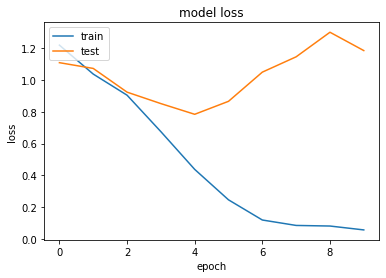

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

LSTM

In [47]:
from keras.layers import Dense,LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [48]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1394, 300)         2153700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 2,373,993
Trainable params: 220,293
Non-trainable params: 2,153,700
_________________________________________________________________
None


In [49]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
28/28 [==============================] - 7s 189ms/step - loss: 1.4627 - acc: 0.5356 - val_loss: 1.1646 - val_acc: 0.5872
Epoch 2/6
28/28 [==============================] - 5s 175ms/step - loss: 1.1449 - acc: 0.5903 - val_loss: 1.1566 - val_acc: 0.5872
Epoch 3/6
28/28 [==============================] - 5s 176ms/step - loss: 1.1579 - acc: 0.5829 - val_loss: 1.1583 - val_acc: 0.5872
Epoch 4/6
28/28 [==============================] - 5s 175ms/step - loss: 1.1481 - acc: 0.5849 - val_loss: 1.1624 - val_acc: 0.5872
Epoch 5/6
28/28 [==============================] - 5s 176ms/step - loss: 1.1546 - acc: 0.5812 - val_loss: 1.1579 - val_acc: 0.5872
Epoch 6/6
35/35 [==============================] - 1s 39ms/step - loss: 1.1458 - acc: 0.5944


In [50]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.1458117961883545
Test Accuracy: 0.5944494009017944


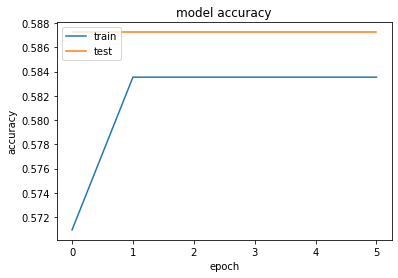

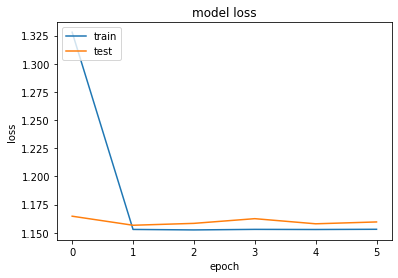

In [51]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()